# Image Classification with **CNN**

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import warnings
import random
from matplotlib import pyplot as plt

In [2]:
TRAIN_DATA_DIR = './dataset/train/images/'
TEST_DATA_DIR = './dataset/test/images'

TRAIN_DATA_SIZE = 532
TEST_DATA_SIZE = 380

NUMBER_OF_CLASSES = 19

IMG_WIDTH = 224
IMG_HEIGHT = 224

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

NUMBER_OF_CHANNELS = 3

LEARNING_RATE = 0.0001

EPOCHS = 10

## Import Datasets

In [3]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

In [4]:
CATEGORIES = list(label_map.values())

In [5]:
def prepare_train_data(TRAIN_DATA_DIR, CATEGORIES, img_width, img_height):
    training_data = []
    path = ""
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img = os.path.join(path, img)
            try:
                img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (img_width, img_height))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(str(e))

    return training_data

In [6]:
def prepare_test_data(TEST_DATA_DIR, CATEGORIES, img_width, img_height):
    test_data = []
    path = ""
    for category in CATEGORIES:
        path = os.path.join(TEST_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img = os.path.join(path, img)
            try:
                img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (img_width, img_height))
                test_data.append([new_array, class_num])
            except Exception as e:
                print(str(e))

    return test_data

In [7]:
training_data = prepare_train_data(TRAIN_DATA_DIR, CATEGORIES, 
                                   IMG_WIDTH, IMG_HEIGHT)

In [8]:
test_data = prepare_test_data(TEST_DATA_DIR, CATEGORIES, 
                              IMG_WIDTH, IMG_HEIGHT)

## Data Preprocessing

In [9]:
random.shuffle(training_data)
random.shuffle(test_data)

In [10]:
val_data_size = int(len(training_data) * 0.3)
val_data = training_data[:val_data_size]
training_data = training_data[val_data_size:]

In [11]:
print("the count of test samples: " + str(len(test_data)))
print("the count of validation samples: " + str(len(val_data)))

the count of test samples: 380
the count of validation samples: 159


In [12]:
X_train = []
y_train = []
for features, classes in training_data:
    X_train.append(features)
    y_train.append(classes)

X_train = np.array(X_train).reshape(-1, 
                                    IMG_WIDTH, 
                                    IMG_HEIGHT, 
                                    NUMBER_OF_CHANNELS
                                   )
y_train = np.array(y_train)
y_train_cat = tf.keras.utils.to_categorical(y_train)

In [13]:
X_val = []
y_val = []
for features, classes in val_data:
    X_val.append(features)
    y_val.append(classes)

X_val = np.array(X_val).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                    NUMBER_OF_CHANNELS)
y_val = np.array(y_val)
y_val_cat = tf.keras.utils.to_categorical(y_val)

In [14]:
X_test = []
y_test = []
for features, classes in test_data:
    X_test.append(features)
    y_test.append(classes)

X_test = np.array(X_test).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                  NUMBER_OF_CHANNELS)
y_test = np.array(y_test)

y_test_cat = tf.keras.utils.to_categorical(y_test)

In [15]:
# TODO: Augment data with Albumenation library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    brightness_range=[0.2, 1.0],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

test_generator = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = ImageDataGenerator(rescale=1./255)

In [16]:
train_flow = train_generator.flow(
        X_train, 
        y_train_cat,
    )

In [17]:
val_flow = test_generator.flow(
        X_val,
        y_val_cat,
      ) 

In [18]:
test_flow = test_generator.flow(
        X_test,
        y_test_cat,
      )

In [ ]:
# TODO: Apply data visualization for data augmentation phase

## Creating Model

In [19]:
dense169 = tf.keras.applications.DenseNet169(include_top=False, 
                                             weights='imagenet', 
                                             input_shape=(
                                                 IMG_WIDTH, 
                                                 IMG_HEIGHT, 
                                                 NUMBER_OF_CHANNELS
                                             )
                                            )

## Training Model

In [20]:
# TODO: Examine the usage of BatchNorm layer in the model
model = tf.keras.models.Sequential()
model.add(dense169)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))

In [21]:
dense169.trainable = False

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# TODO: Examine the effect of batch_size param in training phase
history = model.fit(
        train_flow,
        epochs= 10,
        validation_data= val_flow,    
    )

Epoch 1/10
12/12 [==============================] - 205s 16s/step - loss: 3.0493 - accuracy: 0.0590 - val_loss: 2.9278 - val_accuracy: 0.0818
Epoch 2/10
12/12 [==============================] - 181s 15s/step - loss: 2.9171 - accuracy: 0.0885 - val_loss: 2.8924 - val_accuracy: 0.1069
Epoch 3/10
12/12 [==============================] - 182s 15s/step - loss: 2.8537 - accuracy: 0.1046 - val_loss: 2.8619 - val_accuracy: 0.1132
Epoch 4/10
12/12 [==============================] - 181s 15s/step - loss: 2.8379 - accuracy: 0.1287 - val_loss: 2.7949 - val_accuracy: 0.2013
Epoch 5/10
12/12 [==============================] - 181s 15s/step - loss: 2.7724 - accuracy: 0.1635 - val_loss: 2.7608 - val_accuracy: 0.1887
Epoch 6/10
12/12 [==============================] - 180s 16s/step - loss: 2.7319 - accuracy: 0.1984 - val_loss: 2.6881 - val_accuracy: 0.2767
Epoch 7/10
12/12 [==============================] - 178s 15s/step - loss: 2.6614 - accuracy: 0.1823 - val_loss: 2.5953 - val_accuracy: 0.3019
Epoch 

In [24]:
dense169.trainable = True

set_trainable = False
for layer in dense169.layers:
    if layer.name == 'conv5_block32_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history = model.fit(
        train_flow,
        epochs= 10,
        validation_data= val_flow,
    )

Epoch 1/10
12/12 [==============================] - 257s 21s/step - loss: 2.2868 - accuracy: 0.3217 - val_loss: 2.0401 - val_accuracy: 0.4088
Epoch 2/10
12/12 [==============================] - 194s 16s/step - loss: 2.1494 - accuracy: 0.3405 - val_loss: 1.9535 - val_accuracy: 0.4591
Epoch 3/10
12/12 [==============================] - 192s 16s/step - loss: 2.0716 - accuracy: 0.3673 - val_loss: 1.8279 - val_accuracy: 0.4528
Epoch 4/10
12/12 [==============================] - 191s 16s/step - loss: 2.0087 - accuracy: 0.4048 - val_loss: 1.7829 - val_accuracy: 0.4591
Epoch 5/10
12/12 [==============================] - 207s 18s/step - loss: 1.9213 - accuracy: 0.4102 - val_loss: 1.7070 - val_accuracy: 0.4906
Epoch 6/10
12/12 [==============================] - 183s 16s/step - loss: 1.8326 - accuracy: 0.4343 - val_loss: 1.6055 - val_accuracy: 0.5660
Epoch 7/10
12/12 [==============================] - 183s 15s/step - loss: 1.7216 - accuracy: 0.4826 - val_loss: 1.5517 - val_accuracy: 0.5157
Epoch 

## Prediction & Evaluation

In [27]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label = "training")
    plt.plot(epochs, val_acc, label = "validation")
    plt.legend(loc="upper left")
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label = "training")
    plt.plot(epochs, val_loss, label = "validation")
    plt.legend(loc="upper right")
    plt.title('Training and validation loss')

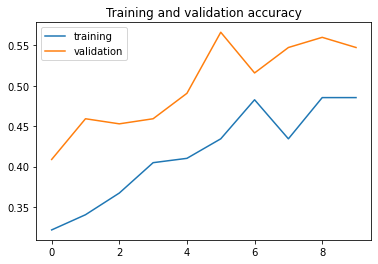

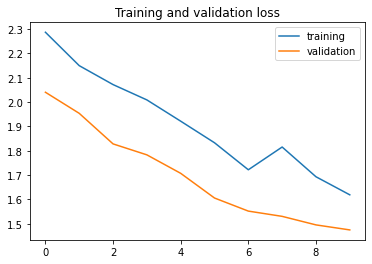

In [28]:
plot_history(history)

In [ ]:
from keras.models import load_model
model = load_model('image_classification_model.h5')

In [29]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

print()

print('Classification Report')
print(classification_report(y_test, 
                            y_pred, 
                            target_names=CATEGORIES))

Confusion Matrix
[[ 0  0  0  0  2  3  0  0  0  6  0  0  0  1  5  0  0  2  1]
 [ 0  0  1  0  0  6  0  0  0  2  0  0  0  6  5  0  0  0  0]
 [ 0  1  4  0  0  8  0  0  0  1  0  0  1  1  3  0  0  1  0]
 [ 0  0  0  0  1  8  0  0  0  1  0  0  0  1  8  0  0  1  0]
 [ 0  0  0  0  0  8  0  0  2  3  0  0  0  3  3  0  0  1  0]
 [ 1  0  4  0  0  7  0  0  1  0  0  0  0  3  4  0  0  0  0]
 [ 1  0  3  0  0  6  0  0  1  1  0  0  0  2  5  0  0  1  0]
 [ 0  0  1  0  0  6  0  0  0  6  0  0  0  1  6  0  0  0  0]
 [ 0  0  3  0  0  6  0  0  1  3  0  0  0  3  4  0  0  0  0]
 [ 0  0  1  0  0 10  0  0  2  4  0  0  1  1  1  0  0  0  0]
 [ 1  0  2  0  0  7  0  0  1  1  0  0  0  3  5  0  0  0  0]
 [ 0  0  3  0  0 10  0  0  1  0  0  0  0  2  3  0  0  1  0]
 [ 0  0  4  0  0  1  0  0  0  1  0  0  0  7  4  0  0  3  0]
 [ 0  0  1  0  0  5  0  0  1  3  0  0  1  2  7  0  0  0  0]
 [ 0  0  1  0  0 10  0  0  1  2  0  0  0  2  4  0  0  0  0]
 [ 0  0  6  0  0  5  0  0  2  1  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  6  0 

c:\users\asreno\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asreno\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asreno\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# model.save("image_classification_model.h5")

In [32]:
loss_and_metrics = model.evaluate(test_flow, verbose=2)
print("Test Loss: ", loss_and_metrics[0])
print("Test Accuracy: ", loss_and_metrics[1])

12/12 - 119s - loss: 1.4410 - accuracy: 0.5895
Test Loss:  1.4409924745559692
Test Accuracy:  0.5894736647605896
